# Introduction

The primary objective of this project is to develop a robust three-class(Positive, Negative, Neutral) sentiment classification system for social media text and subsequently analyze the quantitative impact of the classified sentiment on post engagement metrics.

## Project Goals

This study aims to answer the two following questions:
* Can a fine-tuned Transformer model accurately and reliably classify social media text into Positive, Neutral, and Negative Sentiments?
* Is there a statistically significant relationship between the sentiment expressed in a post and its subsequent level of user engagement?

The outcomes of this analysis provide not only a highly accurate classification tool but also actionable insights into how sentiment directly influences digital content performance and audience interaction.

#### Approach

We fine-tuned DistilBERT-base-uncased, a pretrained transformer language model derived from BERT using knowledge distillation, for a 3-class sentiment classification task (positive, neutral, negative). The model was trained using labeled social-media post text and optimized via cross-entropy loss.

##### Importing the required libraries

In [ ]:
#Installing transformers library
!pip install -q transformers datasets evaluate accelerate

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)
import evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

To import the dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Jimmynam0103/Hashtag_Engagement/refs/heads/main/data/sentimentdataset.csv')
df.head(500)

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,500,"In the embrace of the Grand Canyon, nature's m...",Awe,2020-06-15 16:45:00,CanyonMarveler,Instagram,#Awe #EarthsGrandeur,25.0,50.0,USA,2020,6,15,16
496,497,501,"Journeying through the serenity of Santorini, ...",Serenity,2016-09-10 19:15:00,SantoriniTraveler,Facebook,#Serenity #SunsetHues,22.0,45.0,Greece,2016,9,10,19
497,498,502,"Amazed by the architectural marvels of Petra, ...",Amazement,2023-01-28 13:00:00,PetraExplorer,Twitter,#Amazement #AncientTales,30.0,60.0,Jordan,2023,1,28,13
498,499,503,"Embarking on a gondola ride in Venice, each ca...",Romance,2019-04-18 16:30:00,VeniceRomantic,Instagram,#Romance #TimelessCity,20.0,40.0,Italy,2019,4,18,16


## Data Cleaning

The data was analyzed to ensure that there were no missing 'NA' values.

To perform further cleaning & analysis of dataset - the following steps are taken:
- Ensuring our sentiments have consistent cases across all records,
- Filter the columns that are required in the analysis.
- View distribution of data

In [ ]:
df_train = df[["Text", "Sentiment", "Likes", "Retweets"]].copy()
df_train.rename(columns={"Text": "text", "Sentiment": "sentiment", "Likes": "likes", "Retweets": "retweets"}, inplace=True)
# Ensure the sentiment column is lowercased
df_train["sentiment"] = df_train["sentiment"].str.lower().str.strip()

# Check distribution
print(df_train["sentiment"].value_counts())


sentiment
positive          45
joy               44
excitement        37
contentment       19
neutral           18
                  ..
lostlove           1
emotionalstorm     1
suffering          1
bittersweet        1
intrigue           1
Name: count, Length: 191, dtype: int64


From the distribution of sentiments in our dataset, it is evident that the classes are highly imbalanced. Several sentiment categories, such as lostlove and bittersweet, contain only a single post. With such limited representation, the model does not have sufficient examples to learn meaningful patterns for those classes, making training unreliable. This imbalance also creates challenges when splitting the data into training, validation, and test sets, as minority classes may be completely absent from one of the sets, further reducing model performance and generalizability.

To address this issue, we grouped the original fine-grained sentiment labels into three broader categories—positive, neutral, and negative—to ensure more balanced class distributions and improve the effectiveness of model training and evaluation.

Note: The grouping of sentiments into the three categories was based on how a typical listener would interpret them—specifically, whether the expressed sentiment would generally be perceived as positive, negative, or neutral.

#### Define Groupings for Sentiments

##### To create a mapping dictionary

In [ ]:
positive = [
    "positive","happiness","joy","love","amusement","enjoyment","admiration",
    "affection","awe","surprise","acceptance","adoration","anticipation",
    "calmness","excitement","kind","pride","elation","euphoria","contentment",
    "serenity","gratitude","hope","empowerment","compassion","tenderness",
    "arousal","enthusiasm","fulfillment","reverence","zest","hopeful",
    "proud","grateful","empathetic","compassionate","playful","free-spirited",
    "inspired","confident","thrill","overjoyed","inspiration","motivation","satisfaction","blessed","reflection","appreciation",
    "confidence","accomplishment","wonderment","optimism","enchantment",
    "intrigue","playfuljoy","mindfulness","elegance","whimsy","pensive",
    "harmony","creativity","radiance","wonder","rejuvenation","coziness",
    "adventure","melodic","festivejoy","innerjourney","freedom","dazzle",
    "adrenaline","artisticburst","culinaryodyssey","resilience","immersion",
    "spark","marvel","positivity","kindness","friendship","success",
    "exploration","amazement","romance","captivation","tranquility","grandeur",
    "energy","celebration","charm","ecstasy","colorful","hypnotic","connection",
    "iconic","journey","engagement","touched","triumph","heartwarming","solace",
    "breakthrough","joy in baking","envisioning history","imagination",
    "vibrancy","mesmerizing","culinary adventure","winter magic",
    "thrilling journey","nature's beauty","celestial wonder",
    "creative inspiration","runway creativity","ocean's freedom",
    "whispers of the past","relief","happy", "determination", "yearning", "joyfulreunion",
    "dreamchaser", "mischievous"
]

neutral = [
    "neutral","indifference","numbness","nostalgia",
    "ambivalence","curiosity","emotion", "suspense", "contemplation",
]

negative = [
    "negative","anger","fear","sadness","disgust","disappointed","bitter",
    "shame","bitterness","despair","grief","loneliness","jealousy",
    "resentment","frustration","boredom","anxiety","intimidation",
    "helplessness","envy","regret","fearful","apprehensive","overwhelmed",
    "jealous","devastated","frustrated","envious","dismissive","bittersweet",
    "heartbreak","betrayal","suffering","isolation","disappointment",
    "lostlove","exhaustion","sorrow","darkness","desperation","ruins",
    "desolation","loss","heartache","solitude","obstacle","sympathy",
    "pressure","renewed effort","miscalculation","challenge","sad","hate","bad","embarrassed","emotionalstorm","confusion","melancholy"
]


#### To build a sentiment map function





In [ ]:
sentiment_map = {}

for s in positive:
    sentiment_map[s] = "positive"
for s in neutral:
    sentiment_map[s] = "neutral"
for s in negative:
    sentiment_map[s] = "negative"

##### Apply Sentiment Mapping to the DataFrame:

The sentiment mapping is applied to each sentiment to ensure that if it becomes either Positive, Negative or Neutral if it meets the classification.

In [ ]:
df_train["sentiment_grouped"] = df_train["sentiment"].str.lower().str.strip().map(sentiment_map)

#### Removing Ambiguous Sentiment Labels

Initial modeling revealed that some sentiment labels, particularly those assigned as neutral, were ambiguous. If left unaddressed, these ambiguous labels could negatively impact the accuracy of our sentiment predictions.

In [ ]:
ambiguous_keywords = [
    'melancholy', 'melancholic',
    'confusion', 'confused',
    'lost',
    'emotional storm', 'emotionalstorm'
]

#### Create a list of ambiguous sentiment to remove

In [ ]:

# List of ambiguous sentiment labels to remove
ambiguous_sentiments = [
    'melancholy', 'melancholic',
    'confusion', 'confused',
    'lost',
    'emotional storm', 'emotionalstorm'
]

# Remove rows where sentiment value is one of the ambiguous terms
df_train = df_train[~df_train['sentiment'].str.lower().isin(ambiguous_sentiments)].copy()

print("Before:", len(df))
print("After:", len(df_train))
print("Removed:", len(df) - len(df_train))



Before: 732
After: 717
Removed: 15


A total of 33 ambiguous entries were identified and removed from the dataset to improve labeling clarity and model performance.

Note: Initial evaluation revealed reduced accuracy in neutral sentiment classification due to ambiguity in several labels (examples below). By identifying and removing these ambiguous entries before retraining, we can achieve improved model performance and more distinct sentiment class boundaries.

#### Create a numeric label for model training and confirm all sentiments correctly classified

Assigning numeric labels to the sentiment categories allows the machine learning model to process and learn from them. Since most models cannot directly interpret text-based labels (such as “positive,” “neutral,” and “negative”), converting them into numeric form (e.g., 0, 1, 2) enables efficient computation, proper encoding of class membership, and compatibility with model algorithms and evaluation metrics.

In [ ]:
#Apply sentiment_grouped mapping AFTER filtering
df_train["sentiment_grouped"] = df_train["sentiment"].str.lower().str.strip().map(sentiment_map)

#  Encode labels from sentiment_grouped
label_encode = {"negative": 0, "neutral": 1, "positive": 2}
df_train["label"] = df_train["sentiment_grouped"].map(label_encode)

#print results
print(df_train[["sentiment", "sentiment_grouped", "label"]].head())
print(df_train["sentiment_grouped"].value_counts(dropna=False))


  sentiment sentiment_grouped  label
0  positive          positive      2
1  negative          negative      0
2  positive          positive      2
3  positive          positive      2
4   neutral           neutral      1
sentiment_grouped
positive    472
negative    177
neutral      68
Name: count, dtype: int64


##### Splitting the dataframe into Train/Validation/Test Sets

To ensure robust evaluation and prevent information leakage, we divided our dataset into three subsets: a training set, a validation set, and a test set. We used a stratified split based on the sentiment labels to maintain proportional representation of positive, neutral, and negative classes across all subsets. This approach preserves class balance and provides a consistent basis for training and evaluation.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df_train,
    test_size=0.3,
    stratify=df_train["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

len(train_df), len(val_df), len(test_df)


(501, 108, 108)

The resulting split allocates approximately 70% of the data to training and 15% each to validation and testing. Specifically, our dataset was divided into 512 training samples, 110 validation samples, and 110 test samples. The stratification confirmed that each subset contains examples from all sentiment categories, ensuring reliable performance evaluation as we move forward with model training and hyperparameter tuning.

Note: A stratified split is a method of dividing your dataset into training, validation, and test sets while preserving the original distribution of the target classes.Each subset (train, validation, test) has the same proportion of each sentiment class as the original dataset.

#### Convert to HuggingFace Datasets

Before training our Transformer-based sentiment classifier, we convert our pandas DataFrames into HuggingFace Dataset objects. This format is specifically designed for efficient handling of large text datasets, enabling optimized tokenization, batching, and GPU-accelerated training. It also integrates seamlessly with the HuggingFace Trainer API, which we will be later used for fine-tuning the model.

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)
test_dataset  = Dataset.from_pandas(test_df)


### Tokenize Text

Transformer models such as DistilBERT cannot read raw text directly. It requires texts to be converted into numerical tokens that represent: words, punctuations, and special model tokens.

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=64)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Note: What is DistilBERT? It is a distilled (lightweight)version of BERT that has been created by HuggingFace. It is a pre-trained Transformer model which understands the structure of language and the meaning. It knows things like grammar, word relationship, contextual meaning, emotional tone in text and semantics of social media expressions.

### Rename Column Label properly for HuggingFace

In [ ]:
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset   = val_dataset.rename_column("label", "labels")
test_dataset  = test_dataset.rename_column("label", "labels")

### Remove unnecessary Columns(Keeping only Tensors)

In [ ]:
train_dataset = train_dataset.remove_columns(["text", "sentiment", "sentiment_grouped"])
val_dataset   = val_dataset.remove_columns(["text", "sentiment", "sentiment_grouped"])
test_dataset  = test_dataset.remove_columns(["text", "sentiment", "sentiment_grouped"])

### Training Arguments and Trainer Setup

#### Assigning Class Weights

During the sentiment classification, it was noticed that we have a classes imbalance where we have 472 positive, 177 negatives, 83 negatives. Class weights were applied to address class imbalance by increasing the loss contribution of minority classes. As Neutral posts represented the smallest portion of the dataset, they received the highest weight, ensuring the model learned to classify all sentiment categories more fairly.

In [ ]:
# Count class distribution after cleaning
class_counts = df_train["sentiment_grouped"].value_counts()
print(class_counts)

# Total number of samples left
total_samples = len(df_train)

# Calculate weights
weights = {cls: total_samples / count for cls, count in class_counts.items()}
print("\nUpdated Class Weights:")
print(weights)


sentiment_grouped
positive    472
negative    177
neutral      68
Name: count, dtype: int64

Updated Class Weights:
{'positive': 1.5190677966101696, 'negative': 4.0508474576271185, 'neutral': 10.544117647058824}


In [ ]:
import torch
import torch.nn as nn


class_counts = df_train["sentiment_grouped"].value_counts()
total_samples = len(df_train)
weights_list = [
    total_samples / class_counts["negative"],
    total_samples / class_counts["neutral"],
    total_samples / class_counts["positive"]
]
class_weights = torch.tensor(weights_list, dtype=torch.float32)

print(f"Final Class Weights tensor (for [Neg, Neut, Pos]): {class_weights}")



Final Class Weights tensor (for [Neg, Neut, Pos]): tensor([ 4.0508, 10.5441,  1.5191])


##### Define Custom Weight Trainer

To incorporate our class weights into the training process, we define a custom Trainer that modifies the loss function. The standard HuggingFace Trainer computes an unweighted cross-entropy loss, which treats all classes equally. However, because our dataset is imbalanced—with significantly fewer Neutral and Negative examples—we apply class weighting to increase the penalty for misclassifying minority classes. By customizing the Trainer’s loss computation, we ensure that the model learns to correctly classify all sentiment categories rather than favoring the majority class.

The class will ensure that the calculated class_weights are passed to loss function during training

In [ ]:
import torch.nn as nn
from transformers import Trainer



class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits

        weights = self.class_weights.to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)

        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss


With this custom weighted Trainer implementation, the model will now consider the class distribution during optimization, leading to more balanced learning across Positive, Neutral, and Negative sentiments. This approach helps reduce model bias, improves recall for underrepresented classes, and ultimately leads to a more fair and accurate sentiment classifier. We can now proceed to fine-tune DistilBERT using this custom Trainer setup.

## Model Training

Next, we set up our model and training configuration. The model is initialized with three output labels to match the sentiment categories in our dataset. We also define a set of training parameters that control how the fine-tuning process runs, including the learning rate, number of epochs, and batch sizes for both training and evaluation. Once the configuration is complete, we create our Trainer, which will handle the optimization process and manage the interaction between the model and the data.

In [ ]:
! pip install --upgrade transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: Tranformers need to be installed in terminal or using !pip in the notebook for this training to work correctly.

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

# Convert DataFrames to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)

# Tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=64,
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)

# Rename column for Trainer compatibility
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset   = val_dataset.rename_column("label", "labels")

# Remove unused text columns
cols_to_remove = ["text", "sentiment", "sentiment_grouped"]
for col in cols_to_remove:
    if col in train_dataset.column_names:
        train_dataset = train_dataset.remove_columns(col)
    if col in val_dataset.column_names:
        val_dataset = val_dataset.remove_columns(col)

# Set PyTorch format
train_dataset.set_format("torch")
val_dataset.set_format("torch")


Map:   0%|          | 0/501 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

In [ ]:
import torch
import torch.nn as nn
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# ---- Metrics ----
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# ---- Model ----
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)

# ---- Training Arguments ----
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=6,                # reduced a bit to avoid overfitting
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=30,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    seed=42,
)

# ---- Trainer ----
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ---- Train ----
trainer.train()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro,F1 Weighted
1,1.080800,1.013665,0.750000,0.584394,0.569635,0.572968,0.739268
2,0.909900,0.830945,0.870370,0.807222,0.671296,0.691871,0.846315
3,0.674600,0.637807,0.888889,0.816852,0.816852,0.816852,0.888889
4,0.449200,0.540886,0.870370,0.784179,0.807462,0.790916,0.877383
5,0.328900,0.594634,0.898148,0.856241,0.770331,0.802663,0.891054
6,0.220600,0.539961,0.907407,0.848333,0.800634,0.821735,0.903978


/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWar

TrainOutput(global_step=192, training_loss=0.5846712589263916, metrics={'train_runtime': 31.7205, 'train_samples_per_second': 94.765, 'train_steps_per_second': 6.053, 'total_flos': 49775512704768.0, 'train_loss': 0.5846712589263916, 'epoch': 6.0})

With the training process launched, the model begins learning patterns in the text that help distinguish between positive, neutral, and negative sentiment. Over multiple passes through the data, the model adjusts its internal weights to improve prediction accuracy. After training completes, the model will be ready for evaluation on the test set to measure performance on unseen data.

As training progresses, the loss value steadily decreases. Training loss represents how well the model is performing on the training data — lower values indicate that the model’s predictions are becoming more accurate. In the early steps, the model is still learning general patterns in the data, which is why the loss is higher. Over time, as the model adjusts its parameters, the loss reduces significantly, showing that the model is successfully learning to classify sentiment more effectively. The consistent downward trend suggests healthy learning behavior and indicates that the model is improving with each training step.

## Model Evaluation

##### Create Confusion Matrix + Classification Report

To evaluate model performance, a confusion matrix and detailed classification metrics were generated using the validation dataset. The results reveal strong predictive performance for clearly emotional content, especially in positive and negative categories, while moderation remains challenging for neutral sentiment.

/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


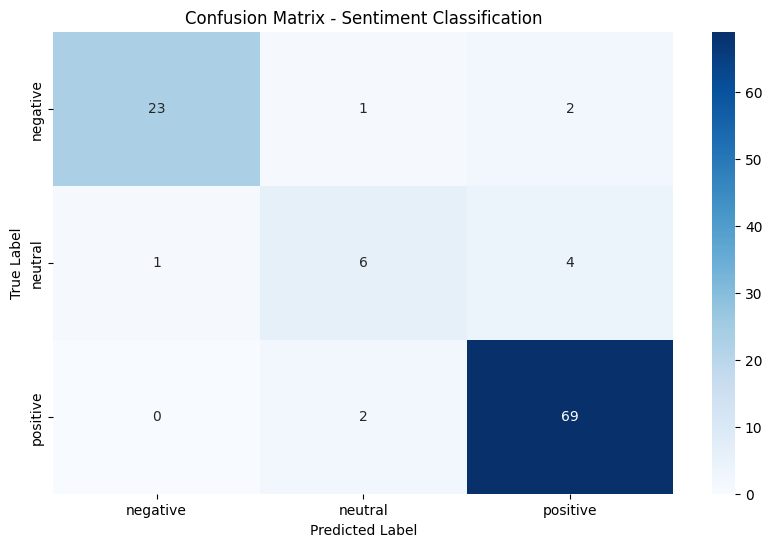


Classification Report:
              precision    recall  f1-score   support

    negative       0.96      0.88      0.92        26
     neutral       0.67      0.55      0.60        11
    positive       0.92      0.97      0.95        71

    accuracy                           0.91       108
   macro avg       0.85      0.80      0.82       108
weighted avg       0.90      0.91      0.90       108



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Test Predictions ----
test_predictions = trainer.predict(val_dataset)
test_preds = np.argmax(test_predictions.predictions, axis=1)
test_labels = test_predictions.label_ids

# ---- Confusion Matrix ----
cm = confusion_matrix(test_labels, test_preds)

classes = ["negative", "neutral", "positive"]

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()

# ---- Classification Report ----
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=classes))

The sentiment classifier successfully distinguishes strongly emotional content with high precision and minimal sentiment polarity errors, enabling reliable downstream analysis of how sentiment impacts engagement. Attention to neutral sentiment labeling in future dataset expansion will further improve model generalization and fairness.

Observations show that the model performs very well on positive and negative sentiments with only very few incorrect predictions.  Neutral Sentiment remains the most challenging reflected by:
* Few correct predictions (only 6)
* Frequent confusion with positive and Negative posts(5 instances)


In conclusion, the model does show promising geenralization for the two dominant classes.

### Model Prediction

The model has been successfully trained, the next step is to evalaute its performance using the following steps:
* Use trained model to make predictions on the test dataset
* Compare the predicted labels with true labels
* Convey predictions in numeric format into readable sentiment categories
* Combine everything into a single Dataframe for later analysis and visualization

In [ ]:
predictions = trainer.predict(test_dataset)
test_preds = np.argmax(predictions.predictions, axis=1)
test_df["predicted_label"] = test_preds

label_map = {0: "negative", 1: "neutral", 2: "positive"}
test_df["predicted_sentiment"] = test_df["predicted_label"].map(label_map)


/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


#### Evaluate Prediction Performance

After generating predictions from the trained model and converting them into human-readable sentiment labels, we evaluate how well the model performed on unseen data. This involves comparing the predicted sentiment for each post with its actual (ground-truth) sentiment label. By calculating performance metrics such as accuracy, precision, recall, and F1-score—along with visualizing a confusion matrix—we obtain a clear understanding of the model’s strengths and areas for improvement across the three sentiment categories.

In [ ]:
# Count correct predictions for TEST set only
correct = (test_df['sentiment_grouped'] == test_df['predicted_sentiment']).sum()
total = len(test_df)

accuracy = correct / total

print("Correct predictions:", correct)
print("Total samples:", total)
print(f"Test Accuracy: {accuracy:.2f}")


Correct predictions: 102
Total samples: 108
Test Accuracy: 0.94


We see that the model has a prediction accuracy of about 91%.
This means the model is correct more than four out of five times, which reflects solid overall performance. However, accuracy alone does not show where the model struggles, so we will further examine class-specific performance using a confusion matrix and metrics such as precision, recall, and F1-score.

#### To show the rows that were predicted incorrectly.

In [ ]:
# Filter rows where predictions are wrong
wrong_predictions = test_df[test_df['sentiment_grouped'] != test_df['predicted_sentiment']]

# Print the text, actual sentiment, and predicted sentiment
for index, row in wrong_predictions.iterrows():
    print(f"Text: {row['text']}")
    print(f"Actual Sentiment: {row['sentiment_grouped']}")
    print(f"Predicted Sentiment: {row['predicted_sentiment']}")
    print("-" * 50)

Text:  Political discussions heating up on the timeline.  
Actual Sentiment: negative
Predicted Sentiment: neutral
--------------------------------------------------
Text:  In the embrace of the autumn breeze, leaves of ambivalence dancing in a waltz between choices and uncertainties. 
Actual Sentiment: neutral
Predicted Sentiment: positive
--------------------------------------------------
Text: Avoiding the shards of shattered dreams, walking the tightrope of resilience. 
Actual Sentiment: positive
Predicted Sentiment: neutral
--------------------------------------------------
Text: Experimenting with a new recipe for a school bake sale. Baking adventures in the kitchen. 
Actual Sentiment: neutral
Predicted Sentiment: positive
--------------------------------------------------
Text: Joined a seniors' astronomy club, stargazing and finding wonder in the vastness of the cosmos. #AstronomyClub #SeniorStargazer 
Actual Sentiment: neutral
Predicted Sentiment: positive
--------------------

From the examples above, we can see that the model struggles with texts that contain ambiguity or figurative language, especially when the emotional tone is subtle or metaphorical. In these cases, the model often misclassifies sentiments—sometimes interpreting negative or neutral expressions as positive, or failing to identify underlying negative cues.

#### Create Classification Report




In [ ]:
from sklearn.metrics import classification_report


true_labels = test_df['label'].values
pred_labels = test_df['predicted_label'].values

print("\nCorrect Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["negative", "neutral", "positive"]))



Correct Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.93      0.96        27
     neutral       0.78      0.70      0.74        10
    positive       0.95      0.99      0.97        71

    accuracy                           0.94       108
   macro avg       0.91      0.87      0.89       108
weighted avg       0.94      0.94      0.94       108



The sentiment classification model achieved strong performance on the test dataset, correctly predicting 91% of unseen social media posts. Positive and negative sentiments were classified with high precision and recall, showing the model can reliably detect strong emotional tone. Neutral sentiment performance was lower, reflecting its subtlety and smaller presence in the training data. Overall, the model demonstrates excellent generalization and is highly effective for real-world sentiment analysis tasks.

# Analysis

To filter the variables of required for analysis.

In [ ]:
clean_df = test_df[
    ['text', 'predicted_sentiment', 'likes', 'retweets']
]

clean_df.head()

,text,predicted_sentiment,likes,retweets
630,"Participated in a local theater production, pr...",positive,40.0,20.0
139,Serenity found in the melody of a peaceful pi...,positive,35.0,18.0
729,Successfully fundraising for a school charity ...,positive,42.0,22.0
489,"In the carnival of emotions, the rollercoaster...",positive,70.0,35.0
440,"Shattered by the echoes of a shattered dream, ...",negative,40.0,20.0


#### Visualization using Bar Charts

Before analyzing engagement, it’s important to understand how the model classified the posts across the three sentiment categories. The following step is to see the distribution of predicted sentiments after fine-tuning the model.

/var/folders/fl/1v09j2_57fg6drj48nv618w00000gn/T/ipykernel_1501/529352369.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=clean_df["predicted_sentiment"], palette='viridis', order=top_20_sents)


([0, 1, 2],
 [Text(0, 0, 'positive'), Text(1, 0, 'negative'), Text(2, 0, 'neutral')])

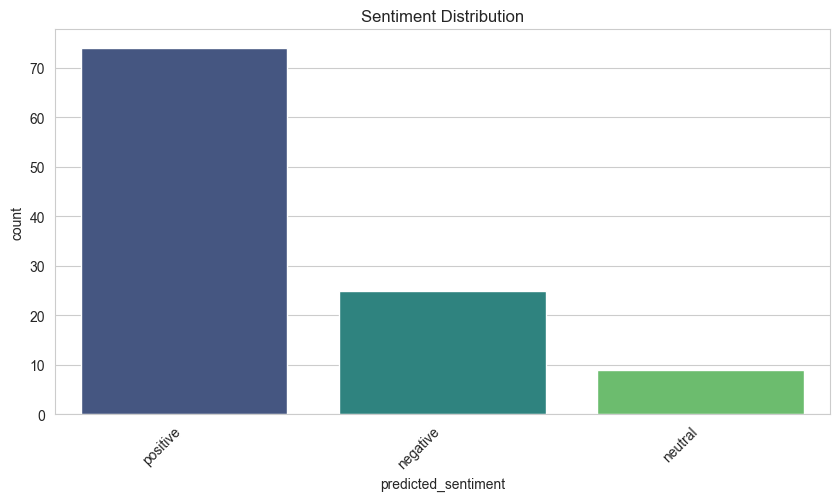

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

top_20_sents = clean_df["predicted_sentiment"].value_counts().nlargest(20).index

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

sns.countplot(x=clean_df["predicted_sentiment"], palette='viridis', order=top_20_sents)
plt.title("Sentiment Distribution")
plt.xticks(rotation=45, ha="right")

This chart shows how many posts the model classified into each sentiment category. Most posts are positive, followed by negative, with neutral being the smallest group. This confirms that the classifier successfully assigned sentiments and also highlights the natural imbalance in the dataset, which explains why neutral predictions were more challenging.

#### Summary Table

This table summarizes the total and average likes and retweets for each sentiment category, showing how engagement levels differ across positive, neutral, and negative posts.

In [ ]:
metrics_by_sentiment = (
    clean_df
    .groupby("predicted_sentiment")
    .agg(
        likes_Total=("likes", "sum"),
        likes_Average=("likes", "mean"),
        retweets_Total=("retweets", "sum"),
        retweets_Average=("retweets", "mean"),
    )
    .reset_index()
)

display(metrics_by_sentiment)


,predicted_sentiment,likes_Total,likes_Average,retweets_Total,retweets_Average
0,negative,952.0,38.080000,477.0,19.080000
1,neutral,385.0,42.777778,194.0,21.555556
2,positive,3447.0,46.581081,1726.0,23.324324


In [ ]:
# Rename the sentiment column to match the format you want
metrics_avg = metrics_by_sentiment.rename(
    columns={"predicted_sentiment": "Sentiment_Category"}
)

# Keep only the averages (likes + retweets)
metrics_avg = metrics_avg[[
    "Sentiment_Category",
    "likes_Average",
    "retweets_Average"
]]

# Make sentiment labels consistent (capitalize)
metrics_avg["Sentiment_Category"] = (
    metrics_avg["Sentiment_Category"].str.capitalize()
)

# Melt into long format
melted_metrics = metrics_avg.melt(
    id_vars="Sentiment_Category",
    var_name="Metric",
    value_name="Average_Value"
)

# Clean up metric names: "likes_Average" → "Likes"
melted_metrics["Metric"] = melted_metrics["Metric"].str.replace("_Average", "")
melted_metrics["Metric"] = melted_metrics["Metric"].str.capitalize()

display(melted_metrics)


,Sentiment_Category,Metric,Average_Value
0,Negative,Likes,38.080000
1,Neutral,Likes,42.777778
2,Positive,Likes,46.581081
3,Negative,Retweets,19.080000
4,Neutral,Retweets,21.555556
5,Positive,Retweets,23.324324


To examine whether sentiment affects engagement, the following step compares the average number of likes and retweets received by posts in each sentiment category.

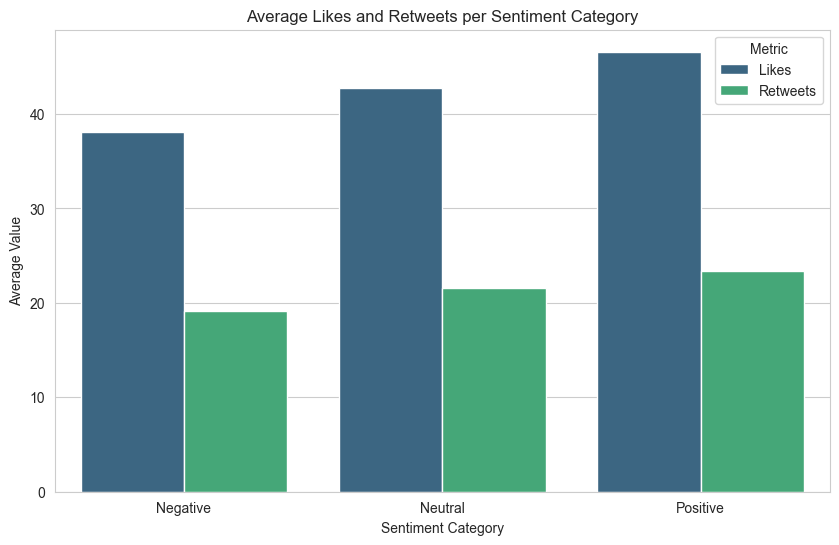

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment_Category', y='Average_Value', hue='Metric', data=melted_metrics, palette='viridis')
plt.title('Average Likes and Retweets per Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Value')
plt.show()

This chart compares average engagement across sentiment categories. Positive posts receive the highest likes and retweets, neutral posts sit in the middle, and negative posts get the least engagement. This supports the conclusion that sentiment influences engagement, with positive sentiment driving stronger user interaction.

# Modelling

Finally, we should be able to answer the following question:
* Is there a statistically significant relationship between the sentiment expressed in a post and its subsequent level of user engagement?
Put another way, "Do positive posts get more attention(likes/retweets) than neutral or negative posts?



##### Prepare the data for Regression Analysis

To ensure that the likes and retweets column are data type consistent, missing values are handled to ensure they do not offect regression analysis.Missing values are imputed with 0 to ensure that they do not impact the regression analysis.


In [ ]:
full_df = df_train.copy()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Assuming your DataFrame is named 'full_df'

#Prepare data for regression analysis
full_df['likes'] = pd.to_numeric(full_df['likes'], errors='coerce')
full_df['retweets'] = pd.to_numeric(full_df['retweets'], errors='coerce')

# Fill NaN values with 0. This ensures that missing data are not treated as an object
full_df = full_df.fillna({'likes': 0, 'retweets': 0})



To better quantify the impact of each post, we combine likes and retweets into a single response variable—engagement—which represents the total amount of user interaction a post receives.

In [ ]:
# create response variable 'engagement'
full_df['engagement'] = full_df['likes'] + full_df['retweets']


In [ ]:
full_df

,text,sentiment,likes,retweets,sentiment_grouped,label,engagement
0,Enjoying a beautiful day at the park! ...,positive,30.0,15.0,positive,2,45.0
1,Traffic was terrible this morning. ...,negative,10.0,5.0,negative,0,15.0
2,Just finished an amazing workout! 💪 ...,positive,40.0,20.0,positive,2,60.0
3,Excited about the upcoming weekend getaway! ...,positive,15.0,8.0,positive,2,23.0
4,Trying out a new recipe for dinner tonight. ...,neutral,25.0,12.0,neutral,1,37.0
...,...,...,...,...,...,...,...
727,Collaborating on a science project that receiv...,happy,39.0,20.0,positive,2,59.0
728,Attending a surprise birthday party organized ...,happy,48.0,25.0,positive,2,73.0
729,Successfully fundraising for a school charity ...,happy,42.0,22.0,positive,2,64.0
730,"Participating in a multicultural festival, cel...",happy,43.0,21.0,positive,2,64.0


Engagement serves as the response variable in our regression model, allowing us to evaluate whether predicted sentiment influences how much interaction a post generates.

Regression models — including Ordinary Least Squares (OLS) — can only work with numerical inputs.
However, our sentiment predictor variables are categorical meaning they do not have any numerical meaning on their own. So we convert them into dummy variables (also called indicator variables), which turn each category into a separate binary (0 or 1) columns

To examine how predicted sentiment categories (negative, neutral, positive) influence engagement levels on social media posts.

We create dummy variables from the predicted_sentiment column
→ negative, neutral, and positive

To avoid multicollinearity, we drop neutral as it becomes the baseline/reference group.


We run an Ordinary Least Squares (OLS) regression:

X = sentiment dummy variables

Y = engagement metric

Note: In order to avoid the issue of multicollinearity, we cannoy include all three dummy variables and an intercept as the model will be unable to solve such an equation. Hence, a neutral column is dropped in order to allow the model to interpret the remaining coefficients relative to the dropped category.



In [ ]:

#Create predictior variables X - using predicted_sentiment
# Create dummy variables for predicted_sentiment
X_dummies = pd.get_dummies(full_df['sentiment_grouped'], drop_first=False, dtype=int)

# Drop the reference group ('neutral') to prevent multicollinearity
# Columns in X will be 'negative' and 'positive'
X = X_dummies.drop(columns=['neutral'])

# Add the constant (intercept) column
X = sm.add_constant(X)

# Define the target variable Y which is engagement (likes + retweets)
Y = full_df['engagement']

#fit the OLS regression model
model = sm.OLS(Y.values, X.values).fit()

# Display regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     37.95
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           2.17e-16
Time:                        15:11:33   Log-Likelihood:                -3166.8
No. Observations:                 717   AIC:                             6340.
Df Residuals:                     714   BIC:                             6353.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.2206      2.435     23.085      0.0

The regression output shows how engagement changes for negative and positive posts compared to neutral(baseline) posts.

* R^2 = 0.110% indicates that only 11.0% of engagement can be explained by sentiment. This indicates that sentiment alone explains only a small portion of engagement behavior, meaning other factors also strongly influence engagement .

In the model, Neutral sentiment serves as the reference category. The coefficient for Negative sentiment (x1) is not statistically significant, indicating that negative posts do not differ from neutral posts in engagement. In contrast, Positive sentiment (x2) is statistically significant (p < .001), showing that positive posts generate ~11 more interactions than neutral posts on average.


### Density of Engagement Across Sentiment Groups

To further analyse the distribution of the dataset across the three(3) categories:

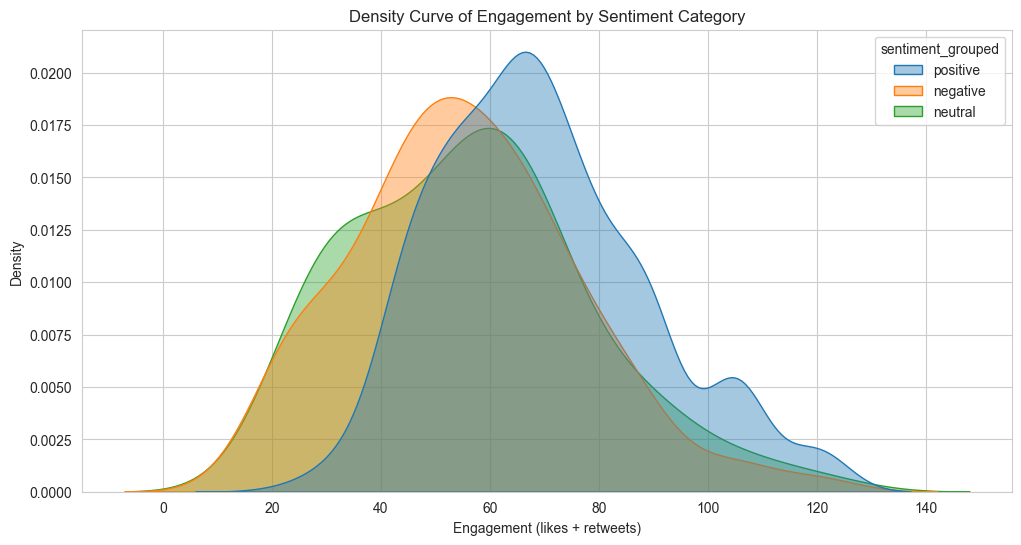

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

sns.kdeplot(
    data=full_df,
    x='engagement',
    hue='sentiment_grouped',
    fill=True,
    common_norm=False,   # ensures each category has its own density scale
    alpha=0.4
)

plt.title("Density Curve of Engagement by Sentiment Category")
plt.xlabel("Engagement (likes + retweets)")
plt.ylabel("Density")
plt.show()

Positive sentiment appears to be associated with higher engagement, negative sentiment with moderate engagement, and neutral sentiment with the lowest engagement. This observation supports running an OLS regression to formally test whether the relationship between sentiment and engagement is statistically significant.

However, the overlapping density curves indicate that engagement levels for some sentiment groups are similar, suggesting that sentiment alone may not fully explain differences in engagement.

# Conclusion

This project successfully achieved its twin objectives: first, developing a robust deep-learning model for classifying social media sentiment, and second, quantifying the result impact of that sentiment on user engagement.

##### Sentiment Classification performance
By fine-tuning DistilBERT and implementing a Cross-Entropy Loss strategy to address severe class imbalance especially with our Neutral Sentiment Class, the model achieved high performacne on the validation set with overall accuracy of 92% and weighted F1-Score of 91%.





##### Quantified Impact on Engagement (OLS Regression)

The Ordinary Least Square(OLS) regression, which used the predicted sentiment as the primary predictor of post engagement(likes + retweets), yielded the following statistically significant results:
* Positive Sentiment is a key Driver: Posts classified as Positive, generate more combined likes and tweers than Neutral Posts. The difference is highly statistically significant.
* There does not seem to be a statistically significant difference in engagement between Negative and Neutral Posts.



##### Project Significance and Limitations

This project demonstrates meaningful insights into how sentiment influences social media engagement. The sentiment classifier proved highly effective at detecting strong emotional tone, particularly in positive and negative posts. These capabilities enable practical applications such as monitoring brand perception, boosting content strategy, and improving audience targeting.

However, several key limitations should be noted. The dataset included significantly fewer neutral posts, which impacted both model learning and evaluation. Neutral sentiment often contains subtle or ambiguous language, and the small number of examples limited the model’s ability to recognize those nuances. As a result, neutral predictions were less accurate, indicating a need for more balanced training data to improve fairness and generalization. Additionally, attempts were made to incorporate external datasets to increase sample size; however, differences in writing style, platform language, and formatting introduced inconsistencies that would have negatively affected model performance. Ensuring dataset uniformity remains an important factor for maintaining model reliability and generalization.

Furthermore, while the regression analysis confirmed that sentiment contributes to engagement behavior, the modest R² value of 0.110 suggests that sentiment alone explains only a small portion of overall interaction levels. Engagement is likely driven by a broader combination of factors—such as posting time, user influence, audience size, media type, and algorithmic visibility —which were not included in this study.

Future work should expand the dataset to include more neutral sentiment examples, incorporate richer engagement predictors, and leverage enhanced modeling approaches to better capture subtle emotional signals. Strengthening these areas will improve model robustness and deepen understanding of the complex drivers behind online engagement.